In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA
import pylab as pl
import warnings
from itertools import cycle, islice

%matplotlib inline

In [151]:
green_data = pd.read_csv('../green.csv')
cols_to_drop = ['experts::{}'.format(i) for i in range(6)]
cols_to_drop.append('consensus')

X = green_data.drop(columns=cols_to_drop)
Y = np.array(green_data['consensus'])

In [152]:
green_data['consensus'].value_counts()

1.0    67
0.0    31
Name: consensus, dtype: int64

In [153]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [154]:
def kMeans(X, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    
    predicted = kmeans.predict(X)
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    return predicted, labels

predicted, labels = kMeans(X, 2)

print(metrics.accuracy_score(Y, predicted))

print(metrics.silhouette_score(X, labels))

0.5
0.2646763805785911


In [145]:
green_data_consensus = pd.read_csv('../green_consensus.csv')
Y_consensus = np.array(green_data['consensus'])

accuracy_score(Y_consensus, predicted)

0.5

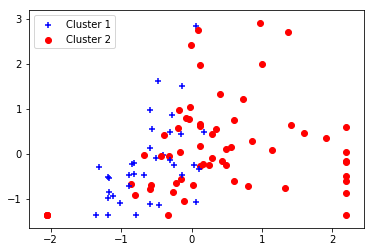

In [146]:
for i in range(0, X.shape[0]):
    if predicted[i] == 0:
        c1 = pl.scatter(X[i,0], X[i,1], c='b', marker="+")
    elif predicted[i] == 1:
        c2 = pl.scatter(X[i,0], X[i,1], c='r', marker="o")
        
pl.legend([c1, c2], ['Cluster 1', 'Cluster 2'])
pl.show()

### Teste Silhouette

In [177]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from matplotlib.colors import colorConverter

def darken_rgb(rgb, p):
    """
    Will darken an rgb value by p percent
    """
    assert 0 <= p <= 1, "Proportion must be [0, 1]"
    return [int(x * (1 - p)) for x in rgb]


def lighten_rgb(rgb, p):
    """
    Will lighten an rgb value by p percent
    """
    assert 0 <= p <= 1, "Proportion must be [0, 1]"
    return [int((255 - x) * p + x) for x in rgb]


def is_luminous(rgb):
    new_color = []

    for c in rgb:
        if c <= 0.03928:
            new_color.append(c / 12.92)
        else:
            new_color.append(((c + 0.055) / 1.055) ** 2.4)
    L = sum([x * y for x, y in zip([0.2126, 0.7152, 0.0722], new_color)])

    return True if L < 0.179 else False


def kmeans_plot(X, y, cluster_centers, ax=None):
    import matplotlib.patheffects as path_effects
    from sklearn.metrics.pairwise import pairwise_distances_argmin_min

    if ax is None:
        ax = plt.gca()

    cmap = cm.get_cmap("Spectral")
    colors = cmap(y.astype(float) / len(cluster_centers))
    ax.scatter(*list(zip(*X)), lw=0, c=colors, s=30)

    offset = max(list(zip(*cluster_centers))[0]) * 0.2

    for i, cluster in enumerate(cluster_centers):
        index, _ = pairwise_distances_argmin_min(cluster.reshape(1, -1), Y=X)
        cluster_color = colorConverter.to_rgb(colors[index[0]])

        if is_luminous(cluster_color) is False:
            cluster_color = darken_rgb(cluster_color, 0.35)

        label = ax.text(x=cluster[0] + offset,
                        y=cluster[1],
                        s='{:d}'.format(i + 1),
                        color=cluster_color)
        label.set_path_effects([path_effects.Stroke(lw=2, foreground='white'),
                                path_effects.Normal()])

    limit = max(*ax.get_xlim(), *ax.get_xlim())

    ax.set_xlim(0, limit)
    ax.set_ylim(0, limit)

    ax.set_xlabel("Feature space for the 1st feature")
    ax.set_ylabel("Feature space for the 2nd feature")
    return ax


def silhouette_plot(X, y, n_clusters, ax=None):
    from sklearn.metrics import silhouette_samples, silhouette_score

    if ax is None:
        ax = plt.gca()

    # Compute the silhouette scores for each sample
    silhouette_avg = silhouette_score(X, y)
    sample_silhouette_values = silhouette_samples(X, y)

    y_lower = padding = 2
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        ith_cluster_silhouette_values = sample_silhouette_values[y == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0,
                         ith_cluster_silhouette_values,
                         facecolor=color,
                         edgecolor=color,
                         alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i + 1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + padding

    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax.axvline(x=silhouette_avg, c='r', alpha=0.8, lw=0.8, ls='-')
    ax.annotate('Average',
                xytext=(silhouette_avg, y_lower * 1.025),
                xy=(0, 0),
                ha='center',
                alpha=0.8,
                c='r')

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_ylim(0, y_upper + 1)
    ax.set_xlim(-0.075, 1.0)
    return ax

AttributeError: Unknown property c

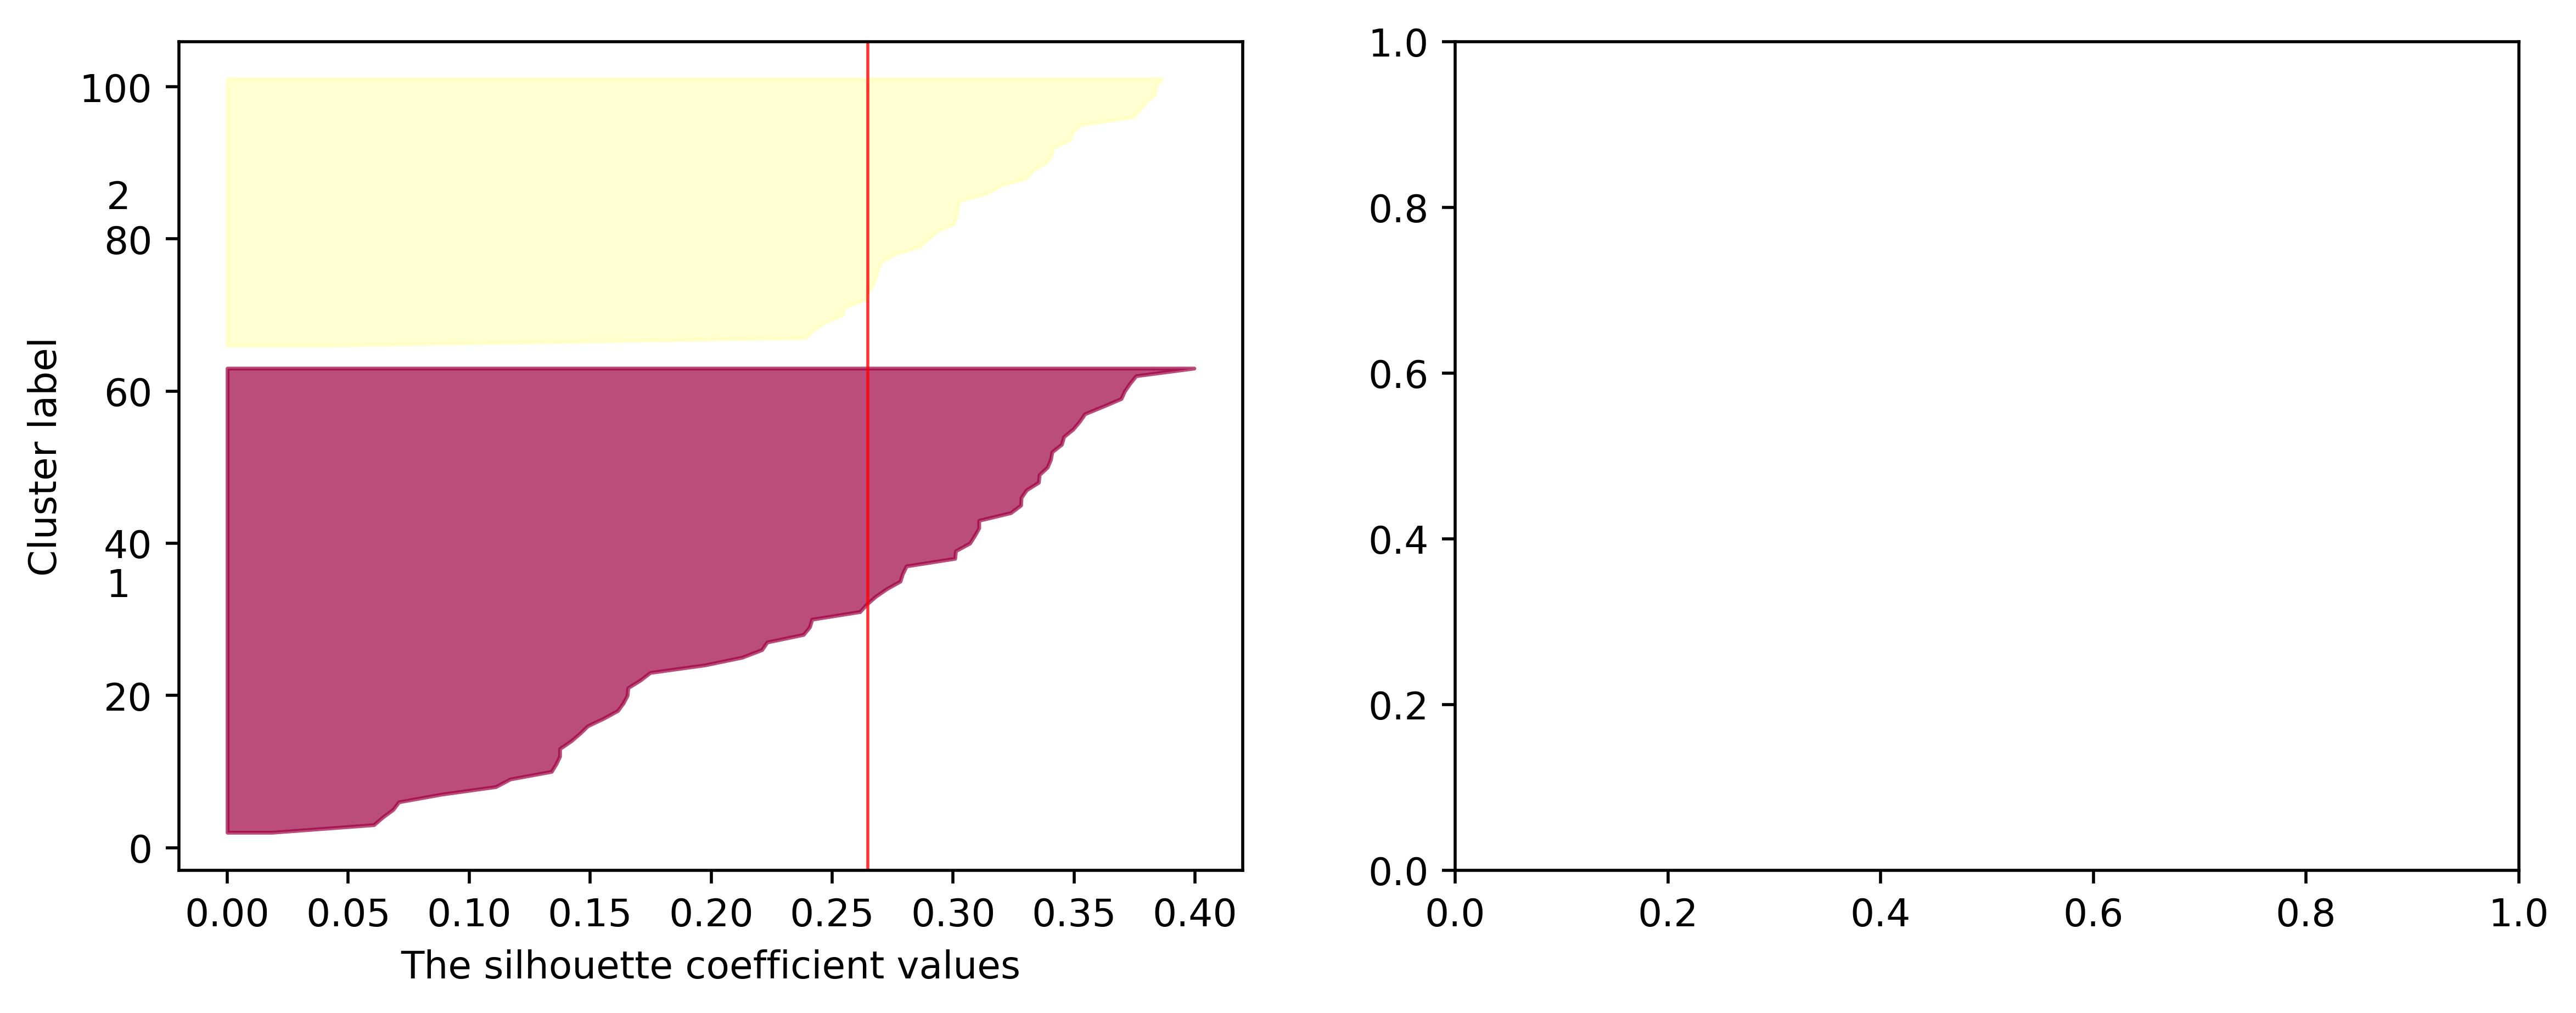

In [178]:
for n_clusters in range(2, 8):
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    y = clusterer.fit_predict(X)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4), dpi=500)
    ax1 = silhouette_plot(X, y, n_clusters=n_clusters, ax=ax1)
    ax2 = kmeans_plot(X, y, clusterer.cluster_centers_, ax=ax2)


    fig.subplots_adjust(top=0.825)
    fig.suptitle(("Silhouette Analysis for KMeans Clustering"
                  "\n$clusters = {}$".format(n_clusters)),
                 fontsize=14, fontweight='bold')
    message = "For n_clusters = {} The average silhouette_score is: {}"
    print(message.format(n_clusters, round(silhouette_score(X, y), 2)))

## Exemplo Lab

In [147]:
green_scaled = X

plot_num = 1
default_base = {'quantile': .3,'eps': .3, 'damping': .9, 'preference': -200, 'n_neighbors': 10, 'n_clusters': 3}
datasets = [
(green_scaled,{'damping':.77,'preference':-240,'quantile':.2,'n_clusters':2}),
(green_scaled, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
(green_scaled, {'eps': .18, 'n_neighbors': 3}),
(green_scaled, {'eps': .15, 'n_neighbors': 2}),
(green_scaled, {}),
(green_scaled, {})]

In [148]:
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)
    X = dataset
    
    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])
    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)
    # Create cluster objects
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering( n_clusters=params['n_clusters'], linkage='ward',
    connectivity=connectivity)
    spectral = cluster.SpectralClustering( n_clusters=params['n_clusters'], eigen_solver='arpack', affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering( linkage="average", affinity="cityblock", n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture( n_components=params['n_clusters'], covariance_type='full')
    clustering_algorithms = (('MiniBatchKMeans', two_means),('AffinityPropagation', affinity_propagation),('MeanShift', ms),('SpectralClustering', spectral),('Ward', ward),('AgglomerativeClustering', average_linkage),('DBSCAN', dbscan),('Birch', birch),('GaussianMixture', gmm))

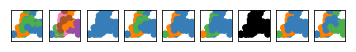

In [149]:
y_preds = {}
for name, algorithm in clustering_algorithms:
    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore",message="the number of connected components of the " +"connectivity matrix is [0-9]{1,2}" +" > 1. Completing it to avoid stopping the tree early.",category=UserWarning)
        warnings.filterwarnings("ignore",message="Graph is not fully connected, spectral embedding" +" may not work as expected.",category=UserWarning)
        algorithm.fit(X)
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)
    y_preds[name] = y_pred
    plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
    if i_dataset == 0:
        plt.title(name, size=18)
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']),int(max(y_pred) + 1))))
    # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred])
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plot_num += 1
    

In [150]:
for name, pred in y_preds.items():
    print('{}: {}'.format(name, accuracy_score(Y_consensus, pred)))

MiniBatchKMeans: 0.4387755102040816
AffinityPropagation: 0.1836734693877551
MeanShift: 0.30612244897959184
SpectralClustering: 0.4489795918367347
Ward: 0.46938775510204084
AgglomerativeClustering: 0.19387755102040816
DBSCAN: 0.0
Birch: 0.46938775510204084
GaussianMixture: 0.3877551020408163
